In [11]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
# from tqdm import tqdm

from multiprocessing import Pool

In [12]:
student_id=21522188

In [28]:
def initialize_population(num_individuals, num_variables):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.

    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến

    Returns:
    pop -- Ma trận (num_individuals, num_variables ) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    pop = np.random.randint(2, size=(num_individuals, num_variables))

    return pop


# optimized for multithreading


def crossover(pop):
    """
    Hàm biến đổi tạo ra các cá thể con.

    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """

    num_individuals, num_parameters = pop.shape

    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    indexes = np.random.permutation(num_individuals)
    # (num_individuals, num_parameters)
    pop = pop[indexes]

    if num_individuals % 2 != 0:
        pop = pop[:-1]
        num_individuals -= 1

    num_pairs = num_individuals // 2

    # i.e.
    # pop1      [0, 1, 2, 3,   4, 5, 6, 7]
    # pop2      [4, 5, 6, 7,   0, 1, 2, 3]

    # t         [0, 1, 2, 3,   0, 1, 2, 3]

    # (num_individuals * num_parameters)
    pop1 = pop.reshape(-1)
    pop2 = pop.reshape((2, num_pairs, num_parameters))[::-1, :, :].reshape((-1))

    # (num_individuals * num_parameters)
    t = np.random.rand(num_pairs * num_parameters)
    t = np.broadcast_to(
        np.expand_dims(t, axis=0), (2, num_pairs * num_parameters)
    ).reshape((-1))

    offsprings = np.where(t < 0.5, pop1, pop2)

    return offsprings.reshape((num_individuals, num_parameters))


def mutation(pop, mutation_prob):

    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # (num_individuals * num_parameters)
    pop = pop.reshape((-1))

    t = np.random.rand(num_individuals * num_parameters)

    # flip bit with a probability of mutation_prob
    res = np.where(t < mutation_prob, 1 - pop, pop)

    res = res.reshape((num_individuals, num_parameters))

    return res

# Benchmark functions

In [14]:
def onemax(pop):
    return pop.sum(axis=-1)

def leadingone(pop):
    first_items = pop[:,0]
    # indice of the first 0
    first_idx = np.argmin(pop, axis=-1)
    # if first_idx == 0, then it's either [1,1,1,1] or [0,0,1,...]
    return np.where(first_idx==0, first_items*(pop.shape[1]), first_idx)


def trap(pop, nof_bits=5):
    # assume len(pop[0]) is divisible by nof_bits

    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # (num_individuals, num_parameters//nof_bits )
    t = pop.reshape((num_individuals, -1, nof_bits)).sum(axis=-1)

    # (num_individuals, num_parameters//nof_bits )
    values = np.where(t < nof_bits, nof_bits - 1 - t, nof_bits)
    
    # (num_individuals )
    return values.sum(axis=-1)


objective_funcs = {
    "Onemax": onemax,
    "LeadingOne": leadingone,
    "Concatenated Trap-5": trap,
}

In [15]:
t = np.array([
    [1,1,1,1,1],
    [1,1,1,1,0],
])
print("onemax", onemax(t))
print("leadingone", leadingone(t))
print("trap", trap(t))

onemax [5 4]
leadingone [5 4]
trap [5 0]


# Selection functions

In [16]:
def truncation_selection(pop, pop_fitness, selection_size):
    return np.argpartition(pop_fitness, -selection_size)[-selection_size:]


def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # select tournament_size opponents from the population selection_size times
    # (selection_size * tournament_size)
    # t_indices = np.concatenate(
    #     [
    #         np.random.choice(num_individuals, size=tournament_size, replace=False)
    #         for _ in range(selection_size)
    #     ]
    # )
    # optimized version
    # https://stackoverflow.com/questions/53891169/numpy-take-many-samples-with-no-replacement-by-row
    t_indices = np.random.rand(selection_size, num_individuals).argpartition(
        tournament_size, axis=1
    )[:, :tournament_size].flatten()

    # fitness of each opponent
    # (selection_size * tournament_size)
    t_fitness = pop_fitness[t_indices]

    # (selection_size, tournament_size)
    t_fitness = t_fitness.reshape((selection_size, tournament_size))

    # winner of each tournament
    # (selection_size)
    t_winners = np.argmax(t_fitness, axis=-1)

    # convert to the actual indices of t_indices
    t_winners = t_winners + np.arange(selection_size) * tournament_size
    return t_indices[t_winners]


def proportional_selection(pop, pop_fitness, selection_size):
    selection_probs = pop_fitness / pop_fitness.sum()
    return np.random.choice(range(len(pop)), size=selection_size, p=selection_probs)


selection_funcs = {
    "tournament": tournament_selection,
    "truncation": truncation_selection,
    "proportional": proportional_selection,
}

# Genetic algorithm

In [17]:
def genetic_algorithm(
    objective=onemax,
    selection_func=truncation_selection,
    num_individuals=32,
    num_parameters=100,
    max_evaluations=100000,
    use_mutation=False,
    seed=49,
):
    np.random.seed(seed)

    pop = initialize_population(num_individuals, num_parameters)
    pop_fitness = objective(pop)
    num_evaluations = num_individuals
    best_fitness = []

    selection_size = num_individuals // 2

    while num_evaluations < max_evaluations:
        best_fitness.append([num_evaluations, np.max(pop_fitness)])

        # tournament selection will have a constant tournament_size of 4
        selected_indices = selection_func(pop, pop_fitness, selection_size)

        selection_set = pop[selected_indices]
        selection_fitness = pop_fitness[selected_indices]

        offspring = crossover(selection_set)
        
        # no mutation
        if use_mutation:
            offspring = mutation(offspring, 0.1)
        
        offspring_fitness = objective(offspring)
        num_evaluations += len(offspring)

        pop = np.vstack([selection_set, offspring])
        pop_fitness = np.concatenate((selection_fitness, offspring_fitness))

    best_fitness.append([num_evaluations, np.max(pop_fitness)])


    return (pop, pop_fitness, best_fitness)



def benchmark(
    objective_func="Onemax",
    selection_func="truncation",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=8,
    init_seed=student_id,
    use_mutation=False
):
    assert objective_func in objective_funcs.keys()
    assert selection_func in selection_funcs.keys()

    res = [
        genetic_algorithm(
            objective=objective_funcs[objective_func],
            selection_func=selection_funcs[selection_func],
            num_individuals=num_individuals,
            num_parameters=num_parameters,
            max_evaluations=max_evaluations,
            seed=init_seed+i,
            use_mutation=use_mutation
        )
        for i in tqdm(range(n_trials))
    ]

    fits = []
    evals = []


    for i, (pop, pop_fitness, best_fitness) in enumerate(res):
        best_fitness = np.array(best_fitness)
        if i == 0:
            evals = best_fitness[:,0]
        fits.append(best_fitness[:,1])
    
    fits = np.array(fits)

    avg = np.mean(fits, axis=0)
    err = np.std(fits, axis=0)

    return evals, avg, err




# Results

In [18]:
def test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=128,
    use_mutation=False,
    init_seed=student_id,
    axes=None,
    ):
    for s in selection_funcs.keys():
        print(objective_func, "-", s)
        evals, avg, err = benchmark(
            objective_func=objective_func,
            selection_func=s,
            n_trials=n_trials,
            num_parameters=num_parameters,
            max_evaluations=max_evaluations,
            num_individuals=num_individuals,
            init_seed=student_id,
            use_mutation=use_mutation
        )
        axes.plot(evals, avg, label=s)
        axes.fill_between(evals, avg+err, avg-err, alpha=0.1)

    axes.set_xlabel("Evaluations")
    axes.set_ylabel("Fitness")

    axes.set_xlim(0, max_evaluations+num_individuals)
    axes.set_title(f"{objective_func} on {num_parameters} Dimensions")
    axes.legend();

In [19]:
print(selection_funcs.keys())
print(objective_funcs.keys())

dict_keys(['tournament', 'truncation', 'proportional'])
dict_keys(['Onemax', 'LeadingOne', 'Concatenated Trap-5'])


Onemax - tournament













100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Onemax - truncation













100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Onemax - proportional













100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


LeadingOne - tournament













100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


LeadingOne - truncation





100%|██████████| 10/10 [00:00<00:00, 40.74it/s]


LeadingOne - proportional






100%|██████████| 10/10 [00:00<00:00, 19.91it/s]


Concatenated Trap-5 - tournament













100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Concatenated Trap-5 - truncation






100%|██████████| 10/10 [00:00<00:00, 21.58it/s]


Concatenated Trap-5 - proportional








100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


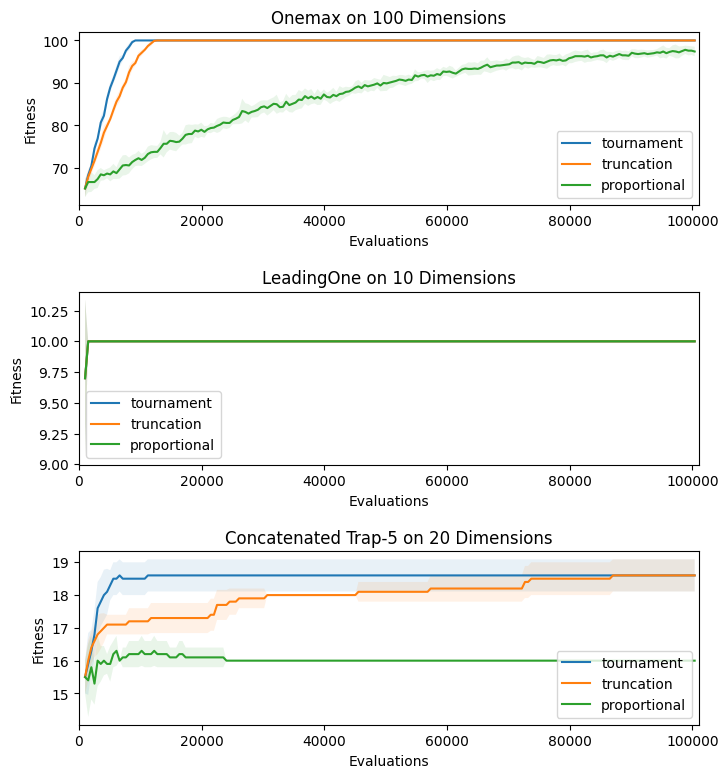

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.5)
test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=1024,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[0],
)
test(
    objective_func="LeadingOne",
    n_trials=10,
    num_parameters=10,
    max_evaluations=100000,
    num_individuals=1024,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[1],
)

test(
    objective_func="Concatenated Trap-5",
    n_trials=10,
    num_parameters=20,
    max_evaluations=100000,
    num_individuals=1024,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[2],
)

Onemax - tournament


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Onemax - truncation


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Onemax - proportional


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


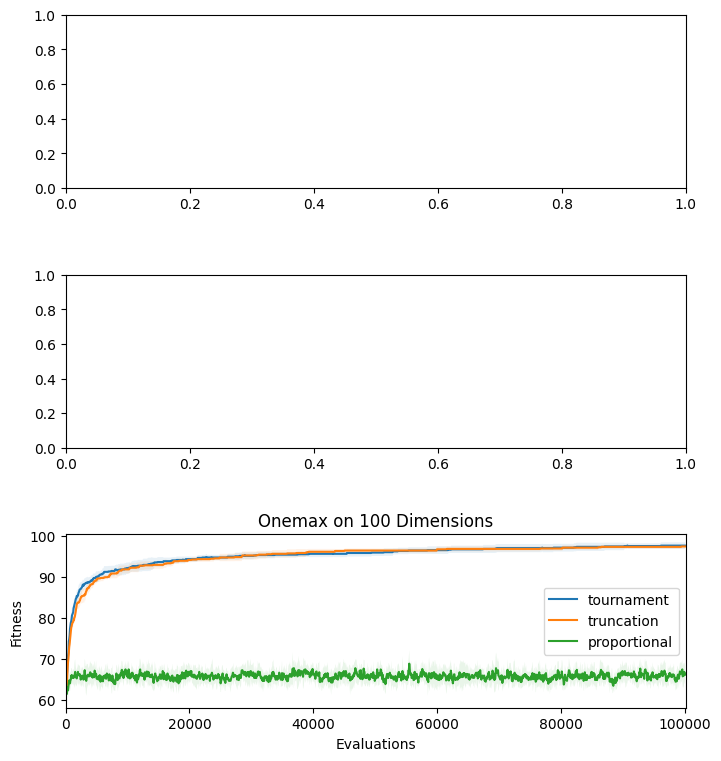

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.5)

test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=64*2,
    use_mutation=True,
    init_seed=student_id,
    axes=ax[2],
)